****🎓 Student Grade Prediction ML Pipeline****

Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Statistical Libraries
from scipy import stats
from scipy.stats import pearsonr

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

DATA LOADING AND INITIAL EXPLORATION

In [2]:
df = pd.read_csv("C:\Data Science(ML)\Project-2\student-mat.csv")

In [3]:
def explore_dataset(df):
    """
    Function to perform initial data exploration
    """
    print("="*50)
    print("DATASET OVERVIEW")
    print("="*50)
    print(f"Dataset shape: {df.shape}")
    print(f"Number of features: {df.shape[1]}")
    print(f"Number of samples: {df.shape[0]}")
    
    print("\n" + "="*50)
    print("DATA TYPES")
    print("="*50)
    print(df.dtypes.value_counts())
    
    print("\n" + "="*50)
    print("MISSING VALUES")
    print("="*50)
    missing_data = df.isnull().sum()
    missing_percent = 100 * missing_data / len(df)
    missing_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percent
    })
    print(missing_df[missing_df['Missing Count'] > 0])
    
    print("\n" + "="*50)
    print("BASIC STATISTICS")
    print("="*50)
    print(df.describe())
    
    return df
df = explore_dataset(df)

DATASET OVERVIEW
Dataset shape: (395, 33)
Number of features: 33
Number of samples: 395

DATA TYPES
object    17
int64     16
Name: count, dtype: int64

MISSING VALUES
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []

BASIC STATISTICS
              age        Medu        Fedu  traveltime   studytime    failures  \
count  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000   
mean    16.696203    2.749367    2.521519    1.448101    2.035443    0.334177   
std      1.276043    1.094735    1.088201    0.697505    0.839240    0.743651   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    2.000000    1.000000    1.000000    0.000000   
50%     17.000000    3.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

           fa

DATA CLEANING AND PREPROCESSING

In [4]:
def clean_and_preprocess_data(df):
    """
    Comprehensive data cleaning and preprocessing function
    """
    print("Starting data cleaning and preprocessing...")
    
    # Create a copy to avoid modifying original data
    df_clean = df.copy()
    
    # 1. Handle Missing Values
    # For numerical columns, use median imputation
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    # For categorical columns, use mode imputation
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    
    # 2. Handle Outliers using IQR method
    def remove_outliers_iqr(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    # Apply outlier removal to key numerical columns (excluding target variables)
    outlier_cols = ['age', 'traveltime', 'studytime', 'absences']
    for col in outlier_cols:
        if col in df_clean.columns:
            initial_shape = df_clean.shape[0]
            df_clean = remove_outliers_iqr(df_clean, col)
            print(f"Removed {initial_shape - df_clean.shape[0]} outliers from {col}")
    
    # 3. Feature Engineering
    
    # Create new features
    if all(col in df_clean.columns for col in ['G1', 'G2']):
        df_clean['grade_trend'] = df_clean['G2'] - df_clean['G1']  # Grade improvement
        df_clean['avg_previous_grades'] = (df_clean['G1'] + df_clean['G2']) / 2
    
    if all(col in df_clean.columns for col in ['Medu', 'Fedu']):
        df_clean['parent_edu_sum'] = df_clean['Medu'] + df_clean['Fedu']
        df_clean['parent_edu_max'] = df_clean[['Medu', 'Fedu']].max(axis=1)
    
    if all(col in df_clean.columns for col in ['Dalc', 'Walc']):
        df_clean['total_alcohol'] = df_clean['Dalc'] + df_clean['Walc']
    
    if all(col in df_clean.columns for col in ['freetime', 'goout']):
        df_clean['social_time'] = df_clean['freetime'] + df_clean['goout']
    
    # 4. Encode Categorical Variables
    label_encoders = {}
    for col in categorical_cols:
        if col in df_clean.columns:
            le = LabelEncoder()
            df_clean[col] = le.fit_transform(df_clean[col].astype(str))
            label_encoders[col] = le
    
    print(f"Data preprocessing completed. Final shape: {df_clean.shape}")
    return df_clean, label_encoders
df_clean, encoders = clean_and_preprocess_data(df)

Starting data cleaning and preprocessing...
Removed 1 outliers from age
Removed 8 outliers from traveltime
Removed 26 outliers from studytime
Removed 15 outliers from absences
Data preprocessing completed. Final shape: (345, 39)


EXPLORATORY DATA ANALYSIS (EDA)

Performing Exploratory Data Analysis...


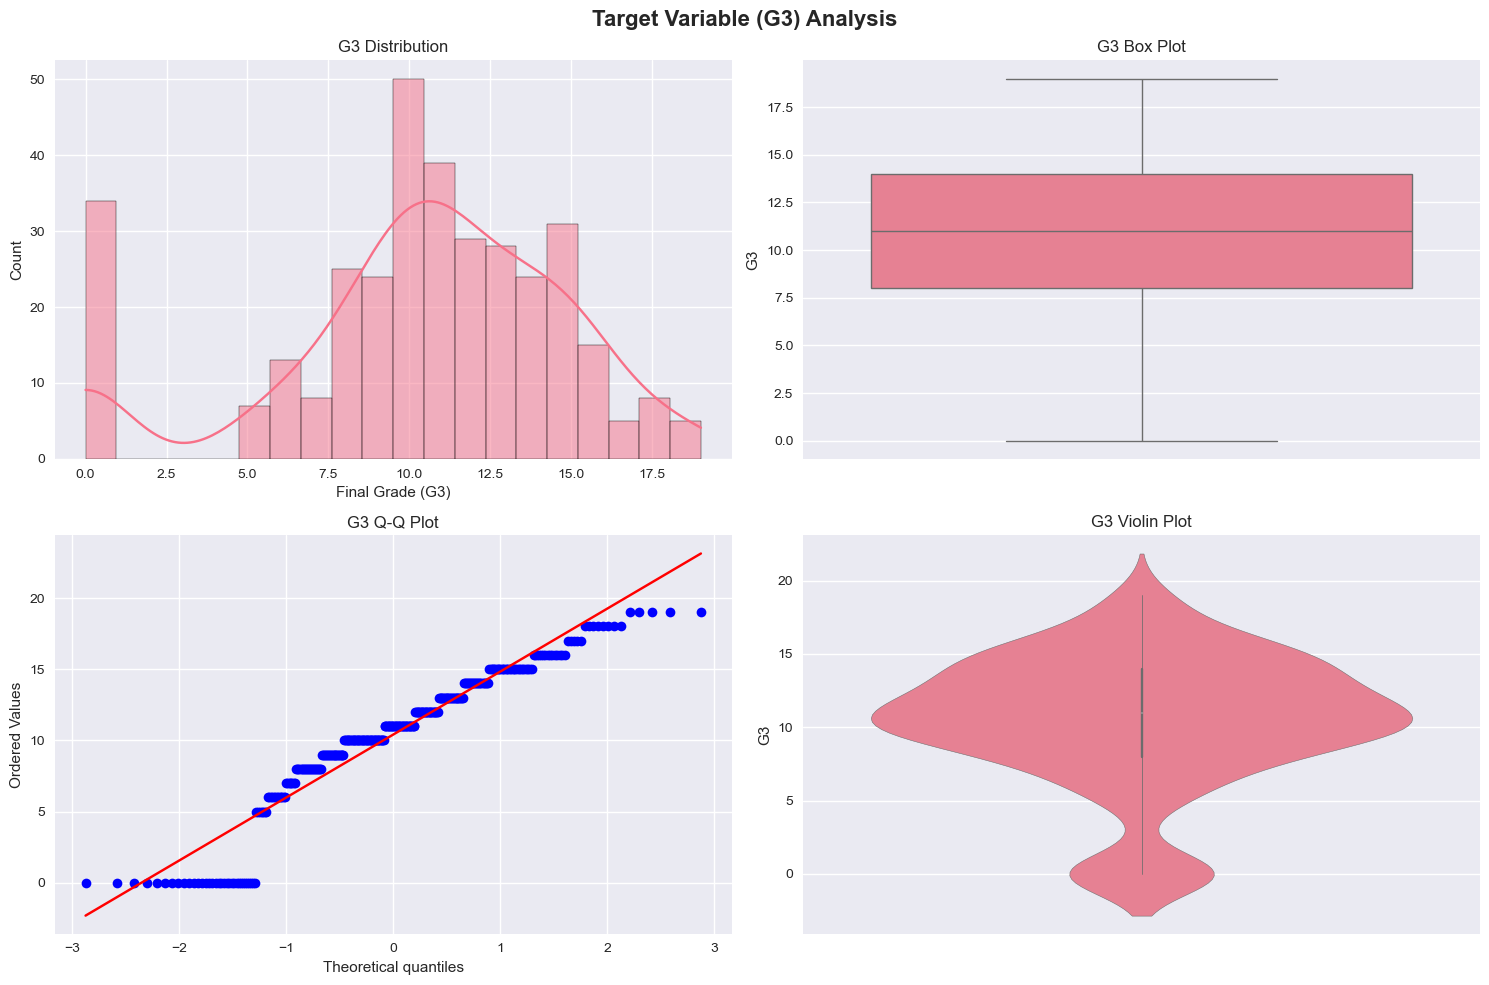

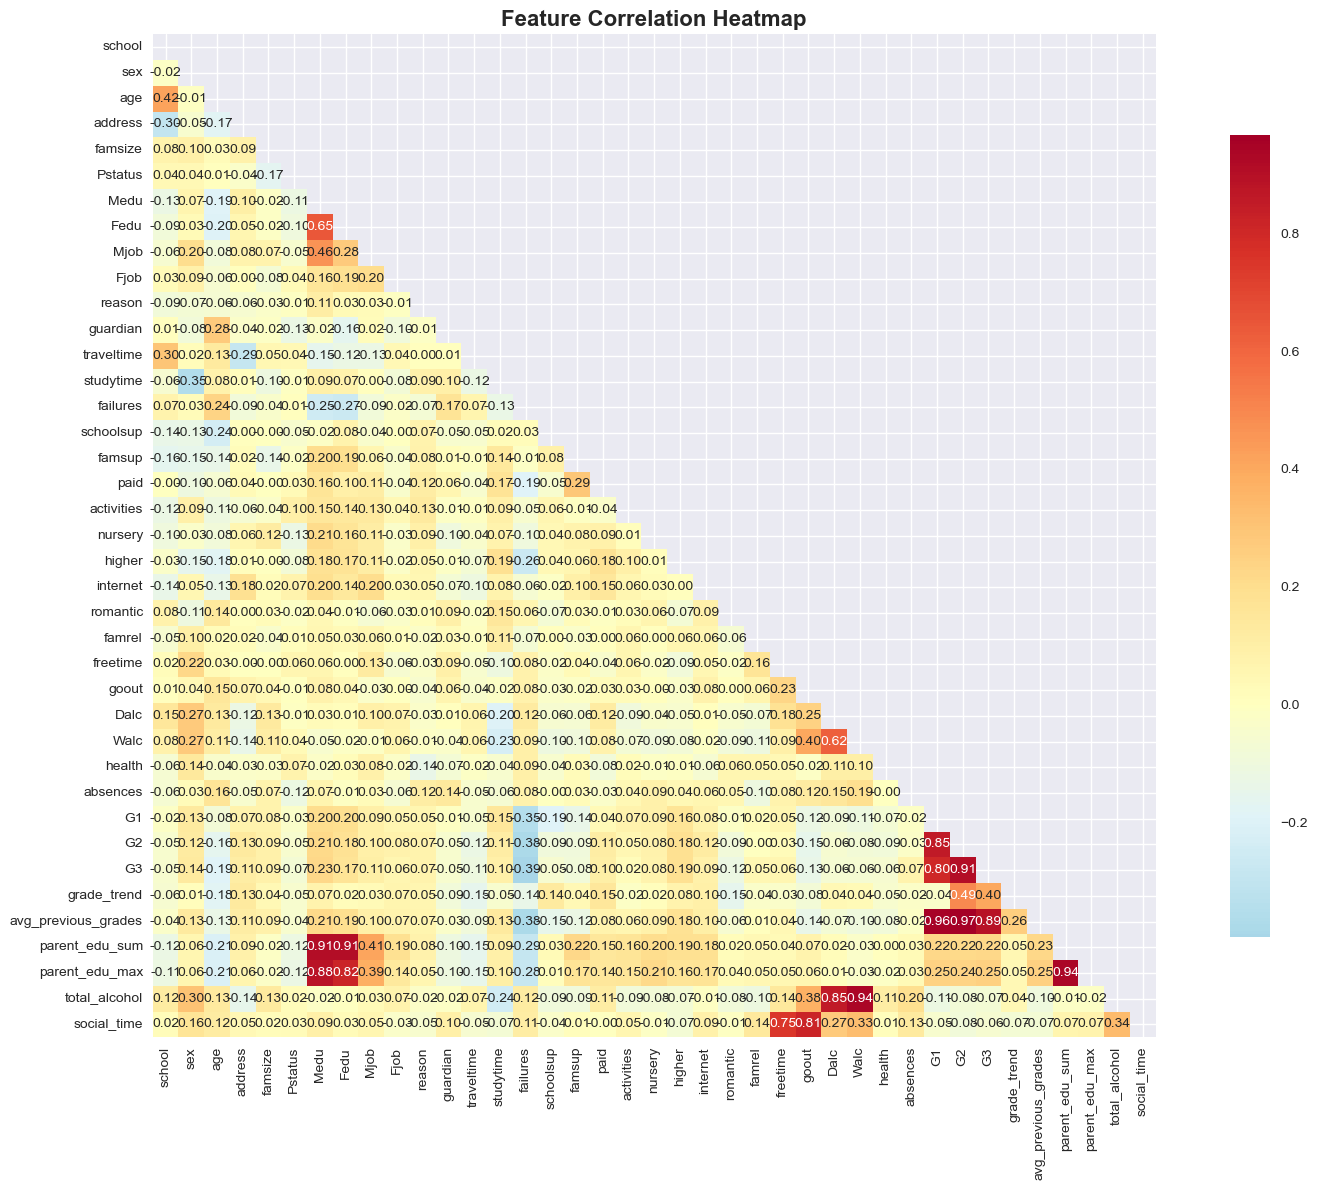

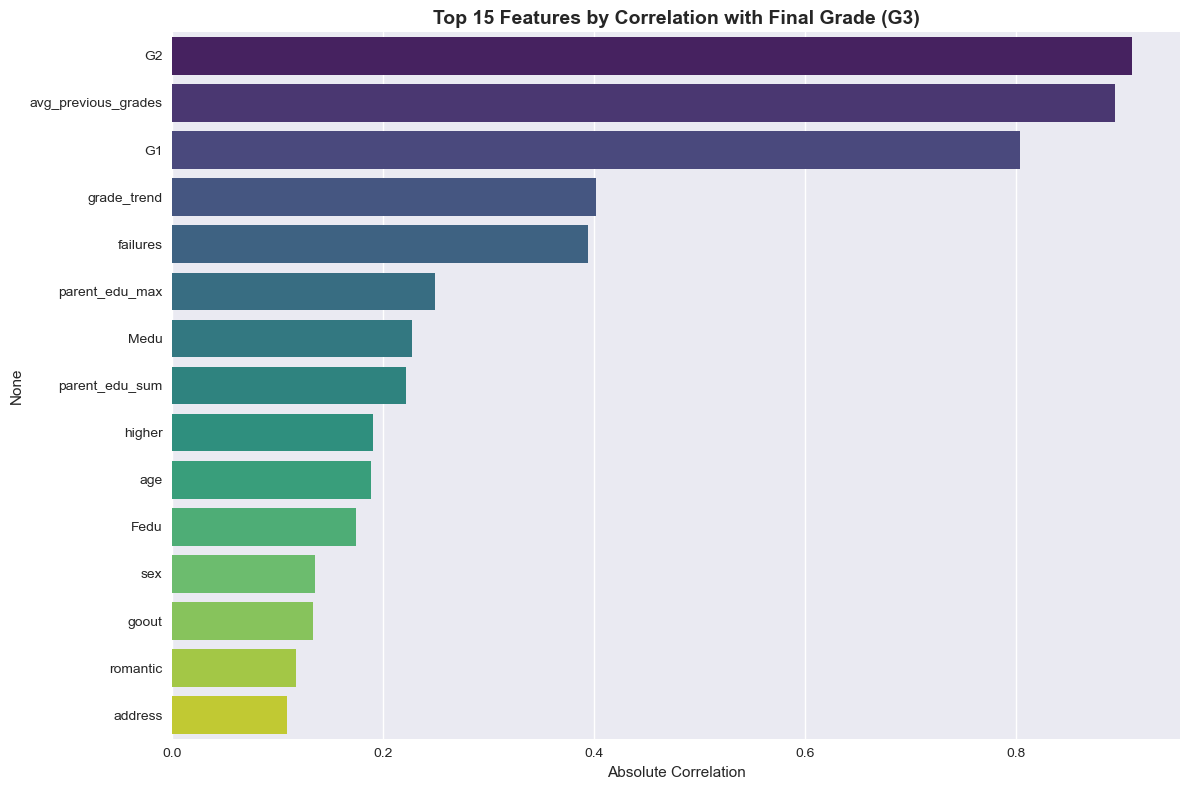

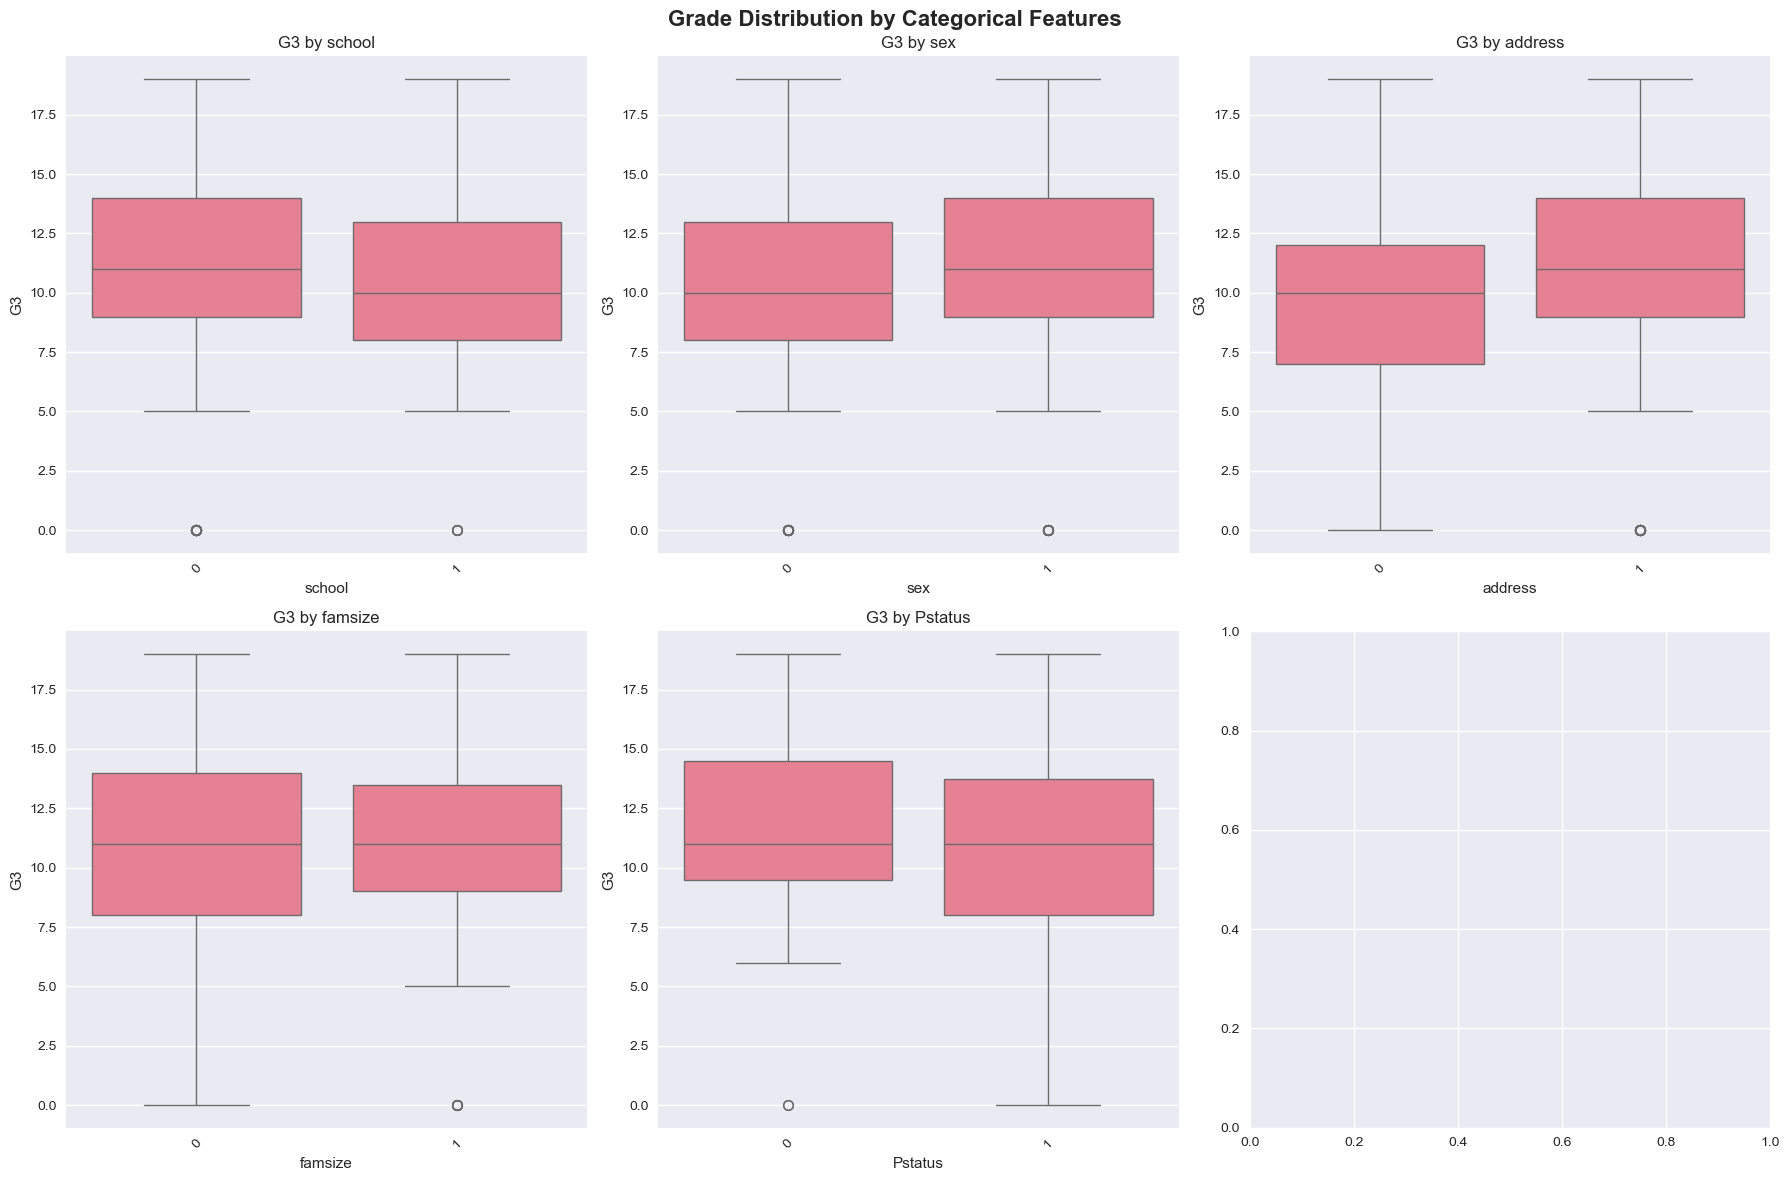

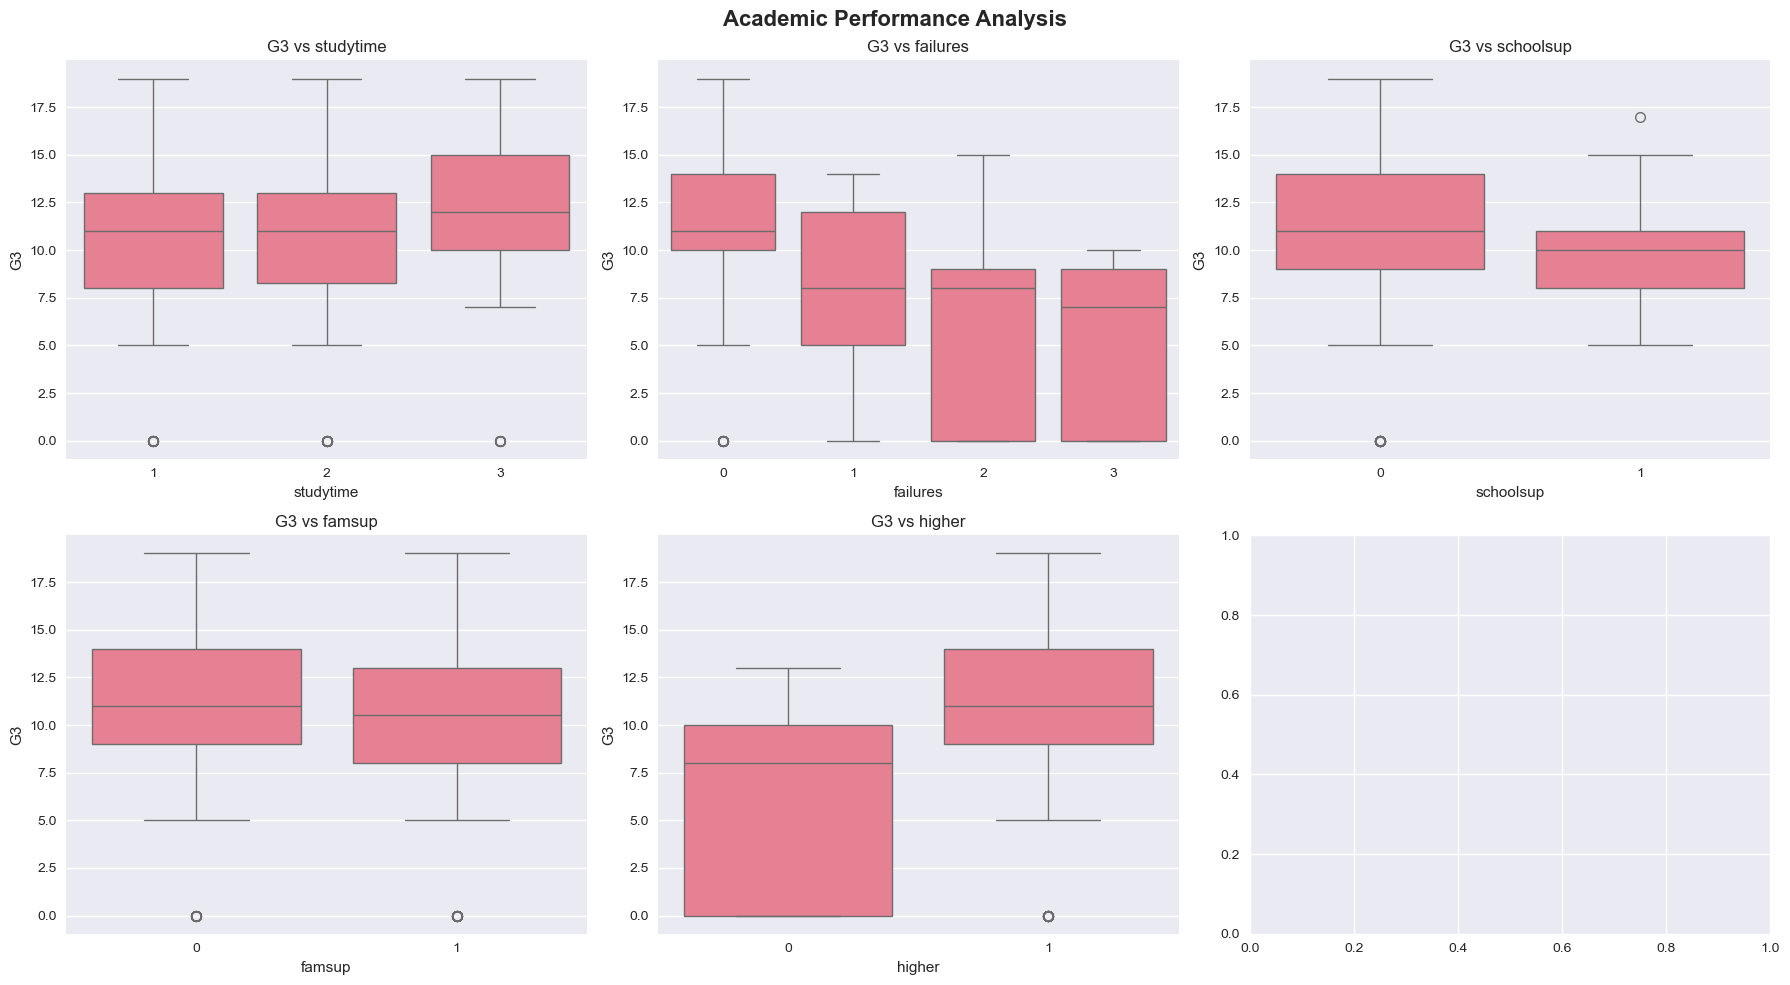

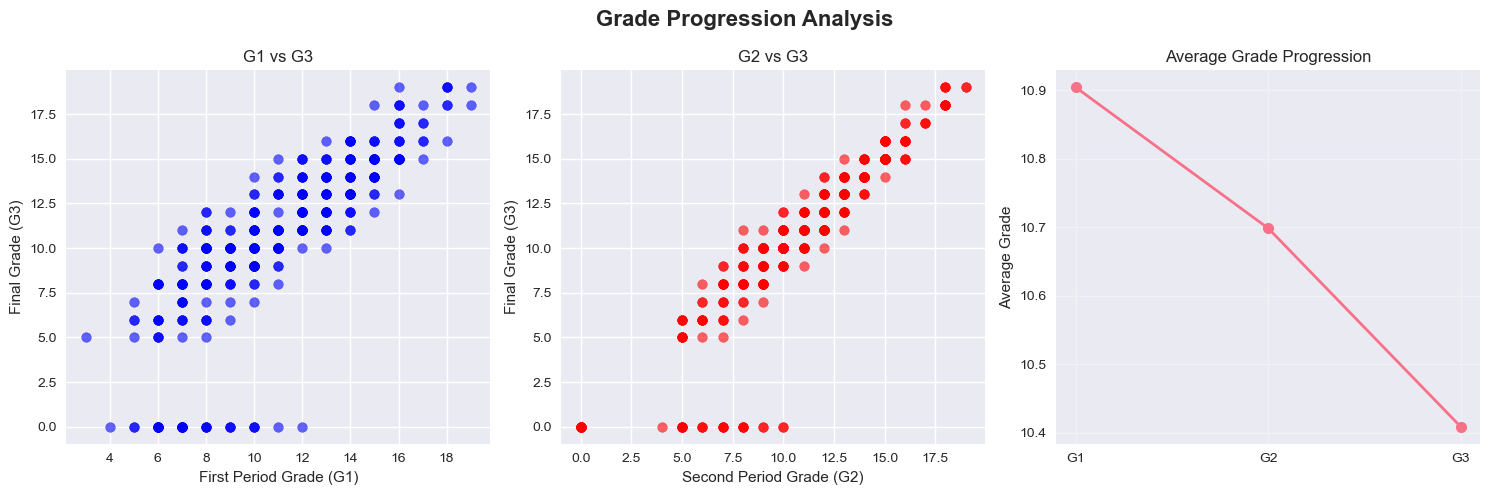


STATISTICAL SUMMARY REPORT
Target Variable (G3) Statistics:
Mean: 10.41
Median: 11.00
Standard Deviation: 4.57
Skewness: -0.79
Kurtosis: 0.42

Grade Distribution:
G3
Medium    151
Low       127
High       33
Name: count, dtype: int64


In [8]:
def perform_comprehensive_eda(df):
    """
    Comprehensive EDA with beautiful visualizations
    """
    print("Performing Exploratory Data Analysis...")
    
    # Set up the plotting parameters
    plt.rcParams['figure.figsize'] = (12, 8)
    
    # 1. Target Variable Distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Target Variable (G3) Analysis', fontsize=16, fontweight='bold')
    
    # Distribution plot
    sns.histplot(df['G3'], bins=20, kde=True, ax=axes[0,0])
    axes[0,0].set_title('G3 Distribution')
    axes[0,0].set_xlabel('Final Grade (G3)')
    
    # Box plot
    sns.boxplot(y=df['G3'], ax=axes[0,1])
    axes[0,1].set_title('G3 Box Plot')
    
    # QQ plot for normality check
    stats.probplot(df['G3'], dist="norm", plot=axes[1,0])
    axes[1,0].set_title('G3 Q-Q Plot')
    
    # Violin plot
    sns.violinplot(y=df['G3'], ax=axes[1,1])
    axes[1,1].set_title('G3 Violin Plot')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Correlation Heatmap
    plt.figure(figsize=(16, 12))
    correlation_matrix = df.select_dtypes(include=[np.number]).corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', 
                center=0, square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 3. Feature Importance based on correlation with target
    target_corr = correlation_matrix['G3'].abs().sort_values(ascending=False)[1:]  # Exclude self-correlation
    
    plt.figure(figsize=(12, 8))
    top_features = target_corr.head(15)
    sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
    plt.title('Top 15 Features by Correlation with Final Grade (G3)', fontsize=14, fontweight='bold')
    plt.xlabel('Absolute Correlation')
    plt.tight_layout()
    plt.show()
    
    # 4. Categorical Variables Analysis
    categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, feature in enumerate(categorical_features):
        if feature in df.columns and i < 6:
            sns.boxplot(data=df, x=feature, y='G3', ax=axes[i])
            axes[i].set_title(f'G3 by {feature}')
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.suptitle('Grade Distribution by Categorical Features', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 5. Study-related Features Analysis
    study_features = ['studytime', 'failures', 'schoolsup', 'famsup', 'higher']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, feature in enumerate(study_features):
        if feature in df.columns and i < 6:
            if df[feature].nunique() <= 10:  # Categorical-like
                sns.boxplot(data=df, x=feature, y='G3', ax=axes[i])
            else:  # Continuous
                sns.scatterplot(data=df, x=feature, y='G3', ax=axes[i])
            axes[i].set_title(f'G3 vs {feature}')
    
    plt.suptitle('Academic Performance Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 6. Grade Progression Analysis
    if all(col in df.columns for col in ['G1', 'G2', 'G3']):
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.scatter(df['G1'], df['G3'], alpha=0.6, color='blue')
        plt.xlabel('First Period Grade (G1)')
        plt.ylabel('Final Grade (G3)')
        plt.title('G1 vs G3')
        
        plt.subplot(1, 3, 2)
        plt.scatter(df['G2'], df['G3'], alpha=0.6, color='red')
        plt.xlabel('Second Period Grade (G2)')
        plt.ylabel('Final Grade (G3)')
        plt.title('G2 vs G3')
        
        plt.subplot(1, 3, 3)
        grade_progression = df[['G1', 'G2', 'G3']].mean()
        plt.plot(['G1', 'G2', 'G3'], grade_progression, marker='o', linewidth=2, markersize=8)
        plt.title('Average Grade Progression')
        plt.ylabel('Average Grade')
        plt.grid(True, alpha=0.3)
        
        plt.suptitle('Grade Progression Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # 7. Statistical Summary Report
    print("\n" + "="*60)
    print("STATISTICAL SUMMARY REPORT")
    print("="*60)
    
    print(f"Target Variable (G3) Statistics:")
    print(f"Mean: {df['G3'].mean():.2f}")
    print(f"Median: {df['G3'].median():.2f}")
    print(f"Standard Deviation: {df['G3'].std():.2f}")
    print(f"Skewness: {df['G3'].skew():.2f}")
    print(f"Kurtosis: {df['G3'].kurtosis():.2f}")
    
    # Check for class imbalance (if treating as classification)
    grade_bins = pd.cut(df['G3'], bins=[0, 10, 15, 20], labels=['Low', 'Medium', 'High'])
    print(f"\nGrade Distribution:")
    print(grade_bins.value_counts())
perform_comprehensive_eda(df_clean)

MODEL PREPARATION AND TRAINING

In [19]:
def prepare_and_train_models(df):
    """
    Prepare data and train multiple ML models
    """
    print("Preparing data for model training...")
    
    # Separate features and target
    X = df.drop('G3', axis=1)
    y = df['G3']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=pd.cut(y, bins=5)
    )
    
    # Scale the features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Training set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")
    
    # Initialize models
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0),
        'SVR': SVR(kernel='rbf', C=100, gamma=0.1)
    }
    
    # Train and evaluate models
    model_results = {}
    trained_models = {}
    
    print("\nTraining models...")
    for name, model in models.items():
        print(f"Training {name}...")
        
        # Use scaled data for distance-based models
        if name in ['SVR', 'Linear Regression', 'Ridge Regression', 'Lasso Regression']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Cross-validation score
        if name in ['SVR', 'Linear Regression', 'Ridge Regression', 'Lasso Regression']:
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
        else:
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
        
        cv_rmse = np.sqrt(-cv_scores.mean())
        
        model_results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'CV_RMSE': cv_rmse
        }
        
        trained_models[name] = model
    
    return model_results, trained_models, X_train, X_test, y_train, y_test, scaler
model_results, trained_models, X_train, X_test, y_train, y_test, scaler = prepare_and_train_models(df_clean)
print(pd.DataFrame(model_results))
print(pd.DataFrame(trained_models))

Preparing data for model training...
Training set size: (276, 38)
Test set size: (69, 38)

Training models...
Training Random Forest...
Training Gradient Boosting...
Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training SVR...
         Random Forest  Gradient Boosting  Linear Regression  \
RMSE          2.388457           2.465821           2.093863   
MAE           1.184783           1.258565           1.439939   
R²            0.741587           0.724576           0.801402   
CV_RMSE       1.606232           1.538525           1.878731   

         Ridge Regression  Lasso Regression       SVR  
RMSE             2.090692          2.431126  2.836884  
MAE              1.432145          1.484662  1.892242  
R²               0.802003          0.732272  0.635446  
CV_RMSE          1.872149          2.132213  2.644382  
                                        Random Forest  \
0   DecisionTreeRegressor(max_features=1.0, random...   
1   DecisionTre

MODEL EVALUATION AND COMPARISON


MODEL PERFORMANCE COMPARISON
                     RMSE     MAE      R²  CV_RMSE
Ridge Regression   2.0907  1.4321  0.8020   1.8721
Linear Regression  2.0939  1.4399  0.8014   1.8787
Random Forest      2.3885  1.1848  0.7416   1.6062
Lasso Regression   2.4311  1.4847  0.7323   2.1322
Gradient Boosting  2.4658  1.2586  0.7246   1.5385
SVR                2.8369  1.8922  0.6354   2.6444


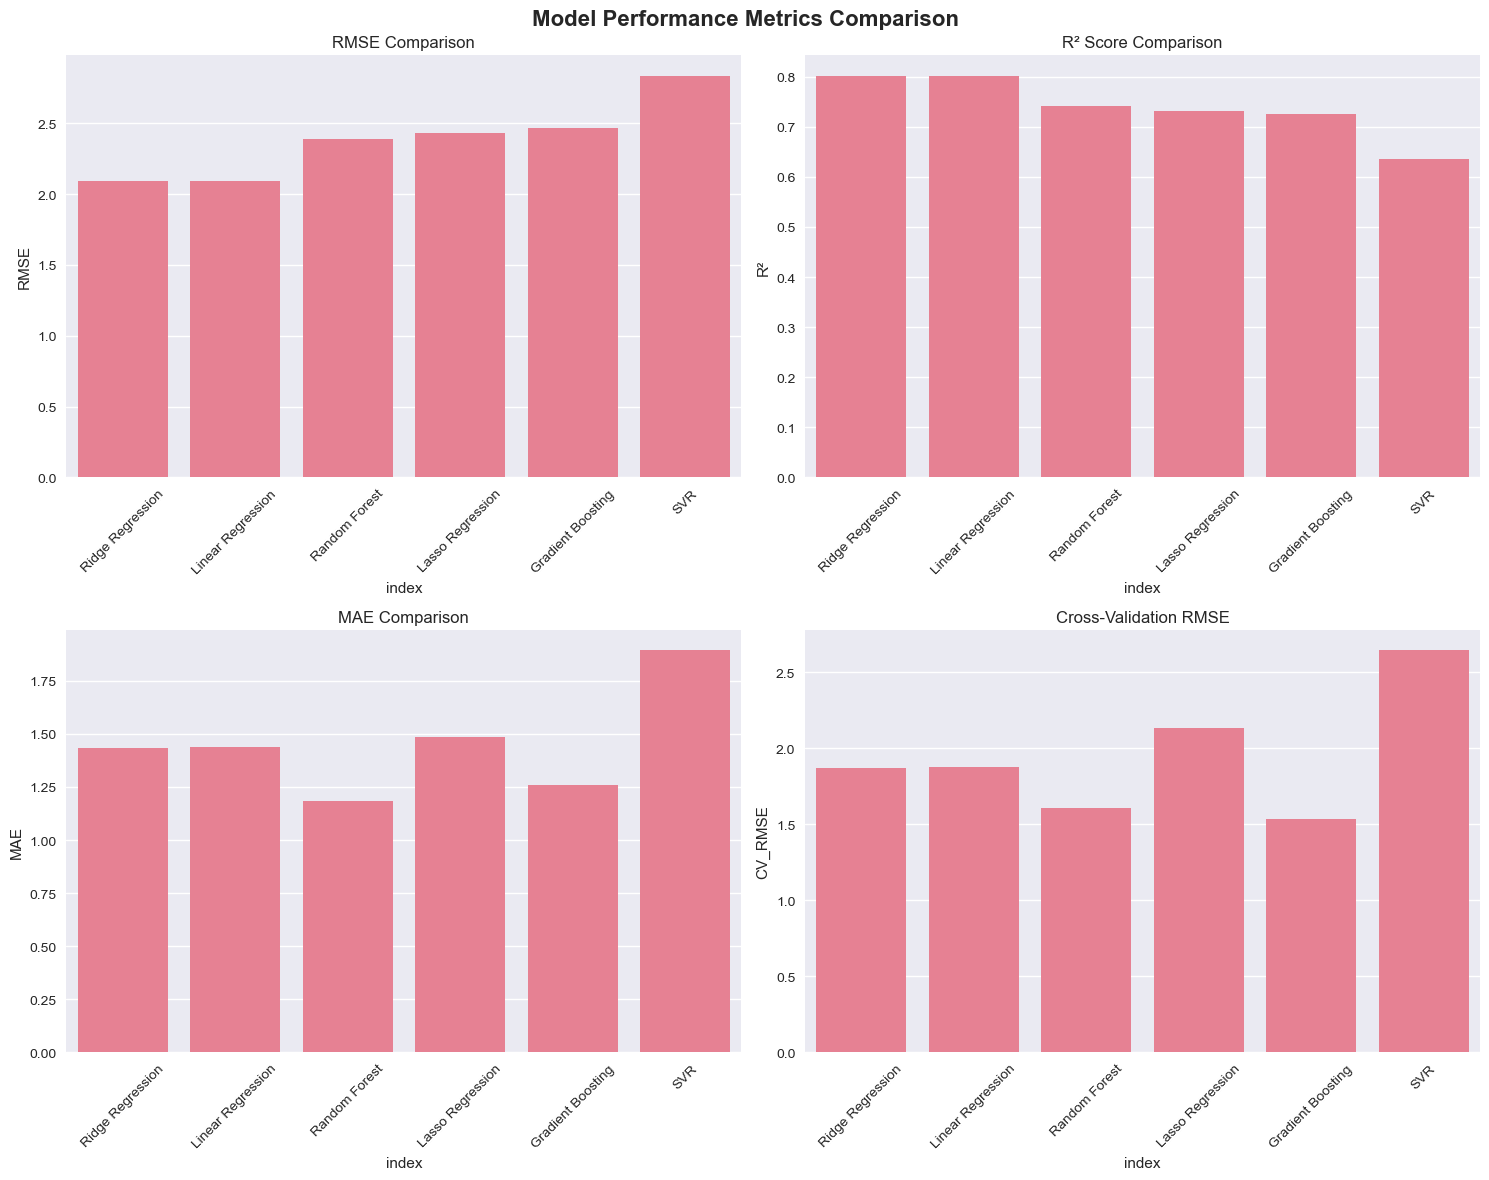


Best Model: Ridge Regression
Best R² Score: 0.8020


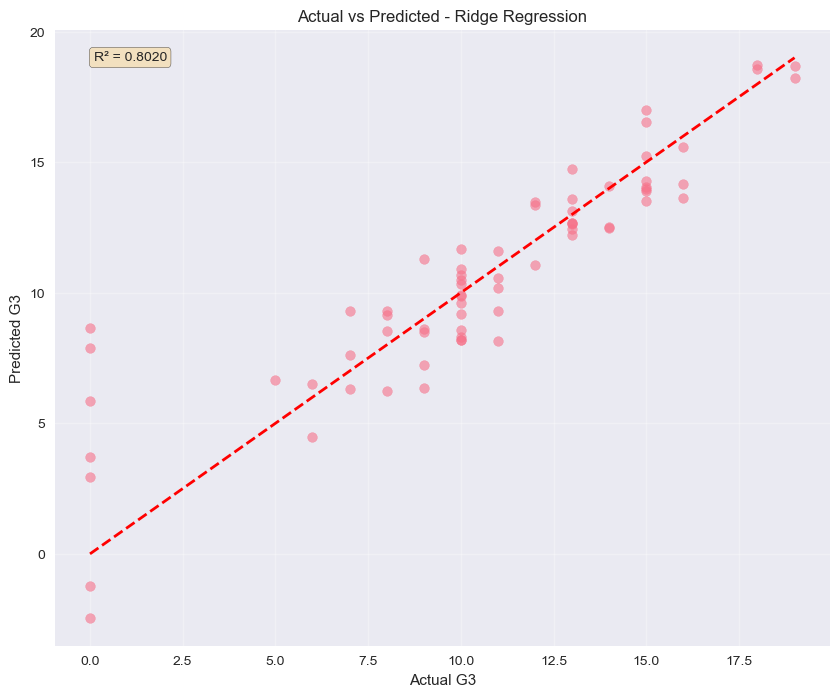

In [21]:
def evaluate_and_compare_models(model_results, trained_models, X_test, y_test, scaler):
    """
    Comprehensive model evaluation and comparison
    """
    print("\n" + "="*60)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*60)
    
    # Create results DataFrame
    results_df = pd.DataFrame(model_results).T
    results_df = results_df.sort_values('R²', ascending=False)
    
    print(results_df.round(4))
    
    # Visualize model comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # RMSE Comparison
    sns.barplot(data=results_df.reset_index(), x='index', y='RMSE', ax=axes[0,0])
    axes[0,0].set_title('RMSE Comparison')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # R² Comparison
    sns.barplot(data=results_df.reset_index(), x='index', y='R²', ax=axes[0,1])
    axes[0,1].set_title('R² Score Comparison')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # MAE Comparison
    sns.barplot(data=results_df.reset_index(), x='index', y='MAE', ax=axes[1,0])
    axes[1,0].set_title('MAE Comparison')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # CV RMSE Comparison
    sns.barplot(data=results_df.reset_index(), x='index', y='CV_RMSE', ax=axes[1,1])
    axes[1,1].set_title('Cross-Validation RMSE')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.suptitle('Model Performance Metrics Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Best model analysis
    best_model_name = results_df.index[0]
    best_model = trained_models[best_model_name]
    
    print(f"\nBest Model: {best_model_name}")
    print(f"Best R² Score: {results_df.loc[best_model_name, 'R²']:.4f}")
    
    # Prediction vs Actual plot for best model
    if best_model_name in ['SVR', 'Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        y_pred_best = best_model.predict(scaler.transform(X_test))
    else:
        y_pred_best = best_model.predict(X_test)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test, y_pred_best, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual G3')
    plt.ylabel('Predicted G3')
    plt.title(f'Actual vs Predicted - {best_model_name}')
    plt.grid(True, alpha=0.3)
    
    # Add R² score to the plot
    r2_best = r2_score(y_test, y_pred_best)
    plt.text(0.05, 0.95, f'R² = {r2_best:.4f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    plt.show()
    
    return best_model_name, best_model
best_model_name, best_model = evaluate_and_compare_models(model_results, trained_models, X_test, y_test, scaler)

HYPERPARAMETER TUNING

In [48]:
def hyperparameter_tuning(X_train, y_train, X_test, y_test):
    """
    Perform hyperparameter tuning for the best models
    """
    print("Performing hyperparameter tuning...")
    
    # Random Forest tuning
    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf_grid = GridSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        rf_param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    rf_grid.fit(X_train, y_train)
    
    # Gradient Boosting tuning
    gb_param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
    
    gb_grid = GridSearchCV(
        GradientBoostingRegressor(random_state=42),
        gb_param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    gb_grid.fit(X_train, y_train)
    
    # Evaluate tuned models
    rf_tuned_pred = rf_grid.best_estimator_.predict(X_test)
    gb_tuned_pred = gb_grid.best_estimator_.predict(X_test)
    
    rf_tuned_r2 = r2_score(y_test, rf_tuned_pred)
    gb_tuned_r2 = r2_score(y_test, gb_tuned_pred)
    
    print(f"Random Forest - Best params: {rf_grid.best_params_}")
    print(f"Random Forest - Tuned R²: {rf_tuned_r2:.4f}")
    print(f"Gradient Boosting - Best params: {gb_grid.best_params_}")
    print(f"Gradient Boosting - Tuned R²: {gb_tuned_r2:.4f}")
    
    # Return the best tuned model
    if rf_tuned_r2 > gb_tuned_r2:
        return rf_grid.best_estimator_, "Tuned Random Forest"
    else:
        return gb_grid.best_estimator_, "Tuned Gradient Boosting"
final_model, model_name = hyperparameter_tuning(X_train, y_train, X_test, y_test)

Performing hyperparameter tuning...
Random Forest - Best params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest - Tuned R²: 0.7555
Gradient Boosting - Best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}
Gradient Boosting - Tuned R²: 0.7218


FEATURE IMPORTANCE ANALYSIS

Analyzing feature importance...


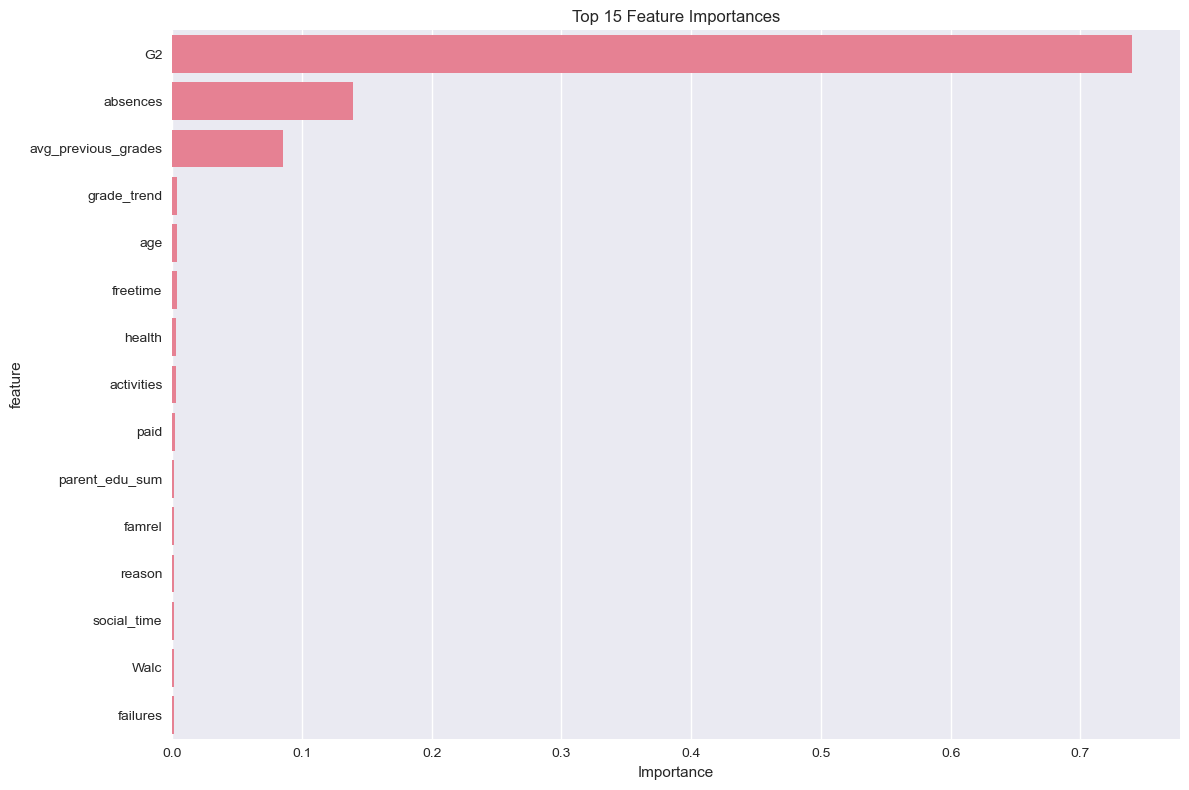

Top 10 Most Important Features:
                feature  importance
31                   G2    0.739823
29             absences    0.139035
33  avg_previous_grades    0.085721
32          grade_trend    0.003795
2                   age    0.003531
24             freetime    0.003321
28               health    0.003171
18           activities    0.002493
17                 paid    0.001780
34       parent_edu_sum    0.001378


In [27]:
def analyze_feature_importance(model, X_train, feature_names):
    """
    Analyze and visualize feature importance
    """
    print("Analyzing feature importance...")
    
    # Get feature importance from the model
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(data=feature_importance_df.head(15), x='importance', y='feature')
        plt.title('Top 15 Feature Importances')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
        
        print("Top 10 Most Important Features:")
        print(feature_importance_df.head(10))
        
        return feature_importance_df
    else:
        print("Model doesn't support feature importance analysis")
        return None
feature_importance = analyze_feature_importance(final_model, X_train, X_train.columns)

MAIN EXECUTION FUNCTION

In [58]:
def main_pipeline():
    """
    Main function to execute the entire ML pipeline
    """
    print("="*60)
    print("STUDENT GRADE PREDICTION - ML PIPELINE")
    print("="*60)
    
    # Instructions for user
    print("\nTo use this pipeline:")
    print("1. Load your dataset using: df = pd.read_csv('your_file.csv')")
    print("2. Ensure your target variable is named 'G3'")
    print("3. Run the functions in order:")
    print("   - df = explore_dataset(df)")
    print("   - df_clean, encoders = clean_and_preprocess_data(df)")
    print("   - perform_comprehensive_eda(df_clean)")
    print("   - model_results, trained_models, X_train, X_test, y_train, y_test, scaler = prepare_and_train_models(df_clean)")
    print("   - best_model_name, best_model = evaluate_and_compare_models(model_results, trained_models, X_test, y_test, scaler)")
    print("   - final_model, model_name = hyperparameter_tuning(X_train, y_train, X_test, y_test)")
    print("   - feature_importance = analyze_feature_importance(final_model, X_train, X_train.columns)")
    
    print("\nRecommended ML Algorithms for your problem:")
    print("1. Random Forest - Excellent for mixed data types, handles missing values well")
    print("2. Gradient Boosting - Great for prediction accuracy, captures complex patterns")
    print("3. XGBoost/LightGBM - State-of-the-art boosting algorithms (install separately)")
    
    print("\nKey considerations for your dataset:")
    print("- You have 33 features with mixed data types")
    print("- Categorical encoding will be crucial")
    print("- Feature engineering can improve performance")
    print("- Cross-validation is important due to potentially small dataset")

if __name__ == "__main__":
    main_pipeline()
# new_predictions = final_model.predict(df_clean)

STUDENT GRADE PREDICTION - ML PIPELINE

To use this pipeline:
1. Load your dataset using: df = pd.read_csv('your_file.csv')
2. Ensure your target variable is named 'G3'
3. Run the functions in order:
   - df = explore_dataset(df)
   - df_clean, encoders = clean_and_preprocess_data(df)
   - perform_comprehensive_eda(df_clean)
   - model_results, trained_models, X_train, X_test, y_train, y_test, scaler = prepare_and_train_models(df_clean)
   - best_model_name, best_model = evaluate_and_compare_models(model_results, trained_models, X_test, y_test, scaler)
   - final_model, model_name = hyperparameter_tuning(X_train, y_train, X_test, y_test)
   - feature_importance = analyze_feature_importance(final_model, X_train, X_train.columns)

Recommended ML Algorithms for your problem:
1. Random Forest - Excellent for mixed data types, handles missing values well
2. Gradient Boosting - Great for prediction accuracy, captures complex patterns
3. XGBoost/LightGBM - State-of-the-art boosting algorithms